# Oil-Storage Tank Instance Segmentation with Mask R-CNN 
------


*by Georgios K. Ouzounis*

In this notebook we will experiment with Mask R-CNN model-training on custom data using transfer learning and try instance segmentation with our new model. The goal is segment oil-storage tanks from very high resoltion satellite images.

**Code**

The code in this notebook makes use of material gathered and modified from several repos listed below:
- [Mask R-CNN](https://github.com/matterport/Mask_RCNN) by [Matterport, Inc](https://matterport.com/),
- [Mask R-CNN extended for TensorFlow2.x](https://github.com/ahmedfgad/Mask-RCNN-TF2) by [Ahmed Gad](https://github.com/ahmedfgad),
- [Image to COCO JSON converter](https://github.com/chrise96/image-to-coco-json-converter), by [chrise96](https://github.com/chrise96).


<img src="https://github.com/georgiosouzounis/instance-segmentation-mask-rcnn/raw/main/images/banner.jpg" width="800"/>

**Data**

The dataset used is posted in [Kaggle](www.kaggle.com) by [Airbus](https://www.airbus.com/) Defense and Space Intelligence and is titled [Airbus Oil Storage Detection Dataset](https://www.kaggle.com/airbusgeo/airbus-oil-storage-detection-dataset). It is a sample dataset of a larger one uploaded in Kaggle for a competition. 

It consists of a number of satellite images (RGB bands only) showing oil-storage tanks in various geographies. The annotation data is given in a CSV file containing the bounding boxes of all tanks that are visually distinctive.

Please review the [License here](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode) and the [Disclaimer here](https://creativecommons.org/licenses/by-nc-sa/4.0/)

----

## Contents

1. [Install libraries](#install-libraries)
2. [Get the image dataset](#get-the-image-dataset)
3. [Prepare the dataset](#prepare-the-dataset)
4. [Get the code](#get-the-code)
5. [Get the COCO weights](#get-the-coco-weights)
6. [Model Training](#model-training)
7. [Model Inference](#model-inference)
8. [Conclusions](#conclusions)
--------


## Install libraries

**IMPORTANT:** Change your Runtime to GPU before starting with this notebook

**Package compatibility - dependency conflicts**

Due to a number of conflicting dependencies between the selected packages, we first need to unistall the latest versions of Keras and Tensorflow and in place install older versions. This project was tested successfully using:
- tensorflow 2.2.0
- keras 2.3.1
- h5py 2.10

**NOTE:** there is no need to restart the Runtime after installation. If the notebook promts you to do so, there is something wrong; close it and re-open it as it may have cached items that trigger conflicts.

In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install h5py==2.10.0

the above takes approximately 2.5 mins to complete

In [2]:
ROOT_DIR = "/content/"

--------
## Get the image dataset <a name="get-the-image-dataset"></a>

In this section we will work with a sample image dataset of [oil-storage tanks](https://www.kaggle.com/airbusgeo/airbus-oil-storage-detection-dataset) obtained from [kaggle.com](www.kaggle.com). The dataset is a kind contribution of Airbus.

### Connect to Kaggle.com

We will import this dataset into our working session directly from Kaggle. To read more on how to import kaggle datasets directly into Google Colab please refer to this [documentation page](https://www.kaggle.com/general/74235).

In [3]:
# install the kaggle API
!pip install -q kaggle

In [4]:
# create a kaggle directory
!mkdir ~/.kaggle 

Right-click on the side bar and select Upload File in the root directory. Choose your kaggle.json token.

In [8]:
# move the token into the kaggle directory
!mv /content/kaggle.json ~/.kaggle/

In [9]:
# change the permisions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 # test it out
 !kaggle datasets list

### Get the dataset

In [10]:
# start the download
%cd /content/
%mkdir dataset
%cd dataset/

/content
/content/dataset


In [11]:
!kaggle datasets download airbusgeo/airbus-oil-storage-detection-dataset

 84% 81.0M/96.8M [00:01<00:00, 41.1MB/s]
100% 96.8M/96.8M [00:01<00:00, 60.8MB/s]


the above takes approximately 20 sec to complete

In [ ]:
!unzip airbus-oil-storage-detection-dataset.zip

In [10]:
!rm *.zip

In [13]:
DATA_DIR = '/content/dataset'

--------
## Prepare the dataset <a name="prepare-the-dataset"></a>

The objective here is to crop each image into same-size chips, each containing one oil tank, using the bounding box coordinates. 

For each tank we need to create a binary reference mask. Each mask will created by drawing a disk centered at the x-y midpoint of the bounding box and has a diameter equal to the side of the bounding box. 

The idea here is: 
1. to reduce the size of images going into the network without sacrificing spatial resolution, i.e. by re-sizing the input;
2. fit multiple chips into the GPU, and thus speed up the training

These images will be stored in a new data-set which in turn will need to be seperated into a training and validation subsets.

With these done, the last step is to create vector annotations, compatible with the MS COCO format and place them in the appropriate directories.

The new data-set directory structure should look like:

```
/content/
  |
  |-- newdataset/
  |   |-- train/
  |   |   |--img001.jpg
  |   |   |--img002.jpg
  |   |   `--annotations.json
  |   |
  |   |-- val/
  |   |   |--img100.jpg
  |   |   |--img101.jpg
  |   |   `--annotations.json
  |   |
  |   `-- masks/
  |       |--img001.png
  |       |--img002.png
  |       |--img100.png
  |       `--img101.png
  |
  `-- Mask_RCNN/
      |-- logs/
      |   `-- weights.h5
      |-- train.py
      |-- .gitignore
      |-- LICENCE
      `-- etc..
```

The ```newdataset/train``` and ```newdataset/val``` directories store the images selected for training and validation respectively, a ratio of approximately 90% to 10% of the total number of images, and the respective annotation files (json).

The ```dataset/masks``` directory contains all mask images of the dataset.

In [14]:
# import some relevant libraries
import sys
import math
import numpy as np
import cv2
import json
import pandas as pd 
import glob
import os
import random

Read the annotation file

In [15]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'annotations.csv'))
anns.head()

,image_id,class,bounds
0,0918a15c-8cfb-4da7-92cf-1f5098a76760,oil-storage-tank,"(1205, 1493, 1231, 1516)"
1,0918a15c-8cfb-4da7-92cf-1f5098a76760,oil-storage-tank,"(1479, 1756, 1507, 1776)"
2,0918a15c-8cfb-4da7-92cf-1f5098a76760,oil-storage-tank,"(1478, 1786, 1518, 1815)"
3,0918a15c-8cfb-4da7-92cf-1f5098a76760,oil-storage-tank,"(2132, 2163, 2148, 2178)"
4,0918a15c-8cfb-4da7-92cf-1f5098a76760,oil-storage-tank,"(2010, 2127, 2024, 2141)"


In [16]:
print("There are a total of: " + str(len(anns)) + " annotated tank instances")

There are a total of: 13592 annotated tank instances


Create a new dataframe that stores the bbox coordinates of each tank for each training image

In [17]:
# create an empty DataFrame with column names only
annotations = pd.DataFrame(columns = ['image_id', 'x', 'y', 'width', 'height', 'class_id'])
annotations

,image_id,x,y,width,height,class_id


In [18]:
# shape up this dataframe to be compatible with the COCO format;
# good for processing the images in their entirety
for index, row in anns.iterrows():
    fname = anns.iloc[index]['image_id'] + '.jpg'
    this_row = anns.iloc[index]['bounds']
    res = this_row.replace('(', '')
    res = res.replace(')', '')
    bbox_list = res.split(",")
    # extract the bbox attributes of each instance annotation
    x = int(bbox_list[0])
    y = int(bbox_list[1])
    w = int(bbox_list[2]) - int(bbox_list[0]) + 1
    h = int(bbox_list[3]) - int(bbox_list[1]) + 1
    # append them in the new dataframe
    annotations = annotations.append({'image_id' : fname, 'x' : x, 'y' : y, 
                                      'width' :  w, 'height': h, 'class_id' : 1}, 
                                     ignore_index = True)

the above takes approximately 1 min to complete

In [19]:
print("There are a total of: " + str(len(annotations)) + " annotated tank instances")
print("and " + str(len(annotations.columns)) + " columns")

There are a total of: 13592 annotated tank instances
and 6 columns


In [20]:
# get the max width and height of tanks from all instances
max_width = annotations["width"].max()
max_height = annotations["height"].max()
max_width, max_height

(109, 115)

In [21]:
CHIP_SIDE = 128 # chip size that ensures all instances fit within it

In [22]:
# the image parser
def get_images(img_dir):
    image_set = glob.glob(img_dir+'/'+'*.jpg')
    return list(set(image_set))

In [23]:
PATH2IMG = '/content/dataset/images/'
image_set = get_images(PATH2IMG)

### Create the chip and mask dataset

In this section we will use the dataframe created earlier to:
1. cut-out same-size instance chips from the training images;
2. create training masks by drawing maximal disks within the bounds of each instance bbox
3. create unique names for all chips and store them along with the masks in a new directory 

<img src="https://miro.medium.com/max/1400/1*p7GqDO8sfSX7kb8R9kX3cQ.png" width="500"/>

In [24]:
%mkdir /content/newdataset/
%mkdir /content/newdataset/images/
%mkdir /content/newdataset/masks/
DATA_DIR = "/content/newdataset/"

In [25]:
# create an empty DataFrame with column names only
new_annotations = pd.DataFrame(columns = ['image_id', 'x', 'y', 'width', 'height', 'class_id'])

In [26]:
PATH2CHIP = '/content/newdataset/images/'
PATH2MASK = '/content/newdataset/masks/'

for i in range(len(image_set)):
  img = cv2.imread(image_set[i])

  # create a temp DF that contains all annotations for a given input image
  new_df = annotations.loc[PATH2IMG + annotations['image_id'] == image_set[i]]
  # reset its index to start from 0
  new_df.reset_index(drop=True, inplace=True)

  for index, row in new_df.iterrows():
      # get the filename and add the index and .PNG extension to it
      this_row = new_df.iloc[index]['image_id']
      fname = this_row.split(".")[0] + '_' + str(index) + ".png"
      # get the bbox attributes
      this_x = new_df.iloc[index]['x']
      this_y = new_df.iloc[index]['y']
      this_w = new_df.iloc[index]['width']
      this_h = new_df.iloc[index]['height']

      # check that the attributes are good 
      if this_w>=1 and this_h>=1:
        #  create the chip
        blank_image = np.zeros((CHIP_SIDE,CHIP_SIDE,3), np.uint8)
        # get the end point x,y- coordinates to define an roi
        end_x = this_x + this_w - 1
        end_y = this_y + this_h - 1
        # the roi contains the desired image patch
        roi = img[this_y:end_y, this_x:end_x]
        # copy the roi into the top-left part of the blank image
        blank_image[:roi.shape[0], :roi.shape[1]]=roi
        cv2.imwrite(PATH2CHIP + fname, blank_image)
        
        # create the mask
        blank_image = np.zeros((CHIP_SIDE,CHIP_SIDE,3), np.uint8)
        mid_x = int(this_w/2)
        mid_y = int(this_h/2)
        cv2.circle(blank_image,(mid_x,mid_y), mid_x, (255,255,255), -1)
        cv2.imwrite(PATH2MASK + fname, blank_image)

        # append the updated info in the new annotation DF
        new_annotations = new_annotations.append({'image_id' : fname, 'x' : 0, 'y' : 0, 
                                          'width' :  this_w, 'height': this_h, 'class_id' : 1}, 
                                        ignore_index = True)
      else:
        print('WARNING: skipping chip ' + fname)

the above takes approximately 1 min to complete

In [27]:
print(len(new_annotations))
print(len(new_annotations.columns))

13591
6


In [26]:
# do some clean-up
#%rm -r /content/dataset/

### Split the images to training and validation sets

In [28]:
%mkdir /content/newdataset/train/
%mkdir /content/newdataset/val/

In [29]:
from sklearn.model_selection import train_test_split
import shutil

# set the path to the images
PATH = '/content/newdataset/images/'

# get all image filenames
list_img=[img for img in os.listdir(PATH) if img.endswith('.png')==True]

# convert the list to a dataframe
df = pd.DataFrame(list_img)

# split 
data_train, data_val, labels_train, labels_test = train_test_split(df[0], df.index, test_size=0.10, random_state=42)

# get the indices of the train and validation DFs
train_idx=list(data_train.index)
val_idx=list(data_val.index)

In [30]:
# absolute path to the training directory 
TRAIN_PATH = "/content/newdataset/train/"

# move the training images to TRAIN_PATH
for i in range(len(train_idx)):
  source = PATH2CHIP + data_train[train_idx[i]]
  destination = TRAIN_PATH + data_train[train_idx[i]]
  dest = shutil.move(source, destination) 

In [31]:
# absolute path to the validation directory 
VAL_PATH = "/content/newdataset/val/"

# move the training images to VAL_PATH
for i in range(len(val_idx)):
  source = PATH2CHIP + data_val[val_idx[i]]
  destination = VAL_PATH + data_val[val_idx[i]]
  dest = shutil.move(source, destination) 

In [ ]:
# do some clean-up
%rm -r /content/newdataset/images/

### Annotate the chip masks 

In this section we will create an MS-COCO compatible annotation file (.JSON) for each of the two sets

Let us first review the targeted layout. At a top level, the json file contains the following:
```
{
  "info"         : info,
  "licenses"     : [license],
  "images"       : [image],
  "annotations"  : [annotation],
  "categories"   : [category],
}
```

which extend to the following:
```
info{
  "year"          : int, 
  "version"       : str,
  "description"   : str,
  "contributor"   : str,
  "url"           : str,
  "date_captured" : datetime,
}

license[{
  "id"            : int,
  "name"          : str,
  "url"           : str,
}]

image[{
  "id"            : int,
  "width"         : int,
  "height"        : int,
  "file_name"     : str,
  "license"       : int,
  "flickr_url"    : str,
  "coco_url"      : str,
  "date_captured" : datetime,
}]

categories[{
  "id"            : int,
  "name"          : str,
  "supercategory" : str,
}]

annotation[{
  "id"            : int,
  "image_id"      : int,
  "category_id"   : int,
  "segmentation"  : RLE or [polygon]
  "area"          : float,
  "bbox"          : [x, y, width, height],
  "iscrowd"       : 0 or 1,
}]
```

In [ ]:
# get the relevant file - annotation code
!wget https://raw.githubusercontent.com/georgiosouzounis/instance-segmentation-mask-rcnn/main/annotation/mask2image.py -O /content/mask2image.py

In [35]:
from mask2image import *
import glob

# Label ids of the dataset
category_ids = {
    "oiltank": 1
}

# Define which colors match which categories in the images
category_colors = {
    "(255, 255, 255)": 1 # oil-tank
}

# Define the ids that are a multiplolygon - none in this case. 
multipolygon_ids = []

# background color
background_color_tupple = (0, 0, 0)

In [33]:
# Get "images" and "annotations" info that need to be placed in the json file
def images_annotations_info(maskpath, image_names, image_idx, background_color_tupple):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    # iterate through all images
    for i in range(len(image_idx)):
        # get the file name
        image_name = image_names[image_idx[i]]
        # the mask image is *.png but the original image can be *.jpg.
        # we make a reference to the original file in the COCO JSON file
        mask_image = os.path.basename(image_name).split(".")[0] + ".png"
        # open the mask image
        mask_image_open = Image.open(maskpath + mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # get the "image" info block and append it 
        image = create_image_annotation(image_name, w, h, image_id)
        images.append(image)

        # get the "annotations" info block:
        # first create one mask per class (category_colors)
        sub_masks = create_sub_masks(mask_image_open, w, h, background_color_tupple)
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # create the vector representation of object contours 
            # and get the "annotations" info block
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)
                                
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                    
                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                    
                    annotations.append(annotation)
                    annotation_id += 1
        image_id += 1
    return images, annotations, annotation_id

### compute the training set annotations

In [36]:
# Get the standard COCO JSON format - template
coco_format = get_coco_json_format()

In [37]:
# create the output file
!touch /content/newdataset/train/annotations.json

In [38]:
# path to the annotation file
ANNOTATION_PATH = "/content/newdataset/train/annotations.json"

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)
    
# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(PATH2MASK, data_train, train_idx, background_color_tupple)

with open(ANNOTATION_PATH,"w") as ANNOTATION_PATH:
  json.dump(coco_format, ANNOTATION_PATH)
        
print("Created %d annotations for training images" % (annotation_cnt))

Created 12231 annotations for training images


the above takes approximately 5 min to complete

### compute the validation set annotations

In [39]:
# Get the standard COCO JSON format - template
coco_format = get_coco_json_format()

In [40]:
# create the output file
!touch /content/newdataset/val/annotations.json

In [41]:
# path to the annotation file
ANNOTATION_PATH = "/content/newdataset/val/annotations.json"
        
# Create category section
coco_format["categories"] = create_category_annotation(category_ids)
    
# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(PATH2MASK, data_val, val_idx, background_color_tupple)

with open(ANNOTATION_PATH,"w") as ANNOTATION_PATH:
  json.dump(coco_format, ANNOTATION_PATH)
        
print("Created %d annotations for validation images" % (annotation_cnt))

Created 1360 annotations for validation images


In [42]:
# search and report the different file-types in the train image directory
!find /content/newdataset/train/ -type f | awk -F. '!a[$NF]++{print $NF}'

png
json


In [43]:
import os.path

# simple version for working with CWD
name = '/content/newdataset/train/'
path, dirs, files = next(os.walk(name))
file_count1 = len(files)

name = '/content/newdataset/val/'
path, dirs, files = next(os.walk(name))
file_count2 = len(files)
print(file_count1 + file_count2)

#expecting 13593 (13591 images + 2 json files)

13593


the above takes approximately 50 sec to complete

------
## Get the code <a name="get-the-code"></a>

Lets get a copy of the Matterport Mask R-CNN project modified for TF2 support 
by Ahmed Gad and further extended by Georgios Ouzounis. It can be found [here](https://github.com/georgiosouzounis/Mask-RCNN-hacked).

In [ ]:
%cd /content/
!git clone https://github.com/georgiosouzounis/Mask-RCNN-hacked.git

In [45]:
# Path to trained weights file
MODEL_DIR = os.path.join(ROOT_DIR, "Mask-RCNN-hacked")

------
## Get the COCO weights <a name="get-the-coco-weights"></a>


needed for transfer learning

In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 -O /content/Mask-RCNN-hacked/mask_rcnn_coco.h5

In [47]:
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")

## Model Training  <a name="model-training"></a>


In this section we will configure our data IO (images & masks) driven by the annotation files we created before, create and customize our model, and start training!

In [48]:
from imgaug import augmenters as iaa
from tqdm import tqdm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask-RCNN-hacked'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [49]:
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

In [50]:
############################################################
#  Dataset
############################################################

class OiltankDataset(utils.Dataset):

  """Load a subset of the custom dataset 
     + dataset_dir: Root directory of the dataset.
     + subset: Subset to load: train or val
  """
  def load_data(self, dataset_dir, subset):
    # Train or validation dataset?
    assert subset in ["train", "val"]
    # include the subset in the dataset path
    dataset_dir = os.path.join(dataset_dir, subset)
    # open the relevant annotations file (json) 
    coco = COCO("{}/annotations.json".format(dataset_dir))
    # retrieve the image ids
    image_ids = list(coco.imgs.keys())
    # add classes; we have only one class to add
    self.add_class("oiltank", 1, "oiltank")
    class_ids = [1]
    # add images
    for i in image_ids:
      self.add_image(
        "oiltank", # the image source
        image_id=i, # the image ID
        path=os.path.join(dataset_dir, coco.imgs[i]['file_name']), # the image path
        width=CHIP_SIDE, #  image width
        height=CHIP_SIDE, # image height
        annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], catIds=class_ids, iscrowd=None)))
      
  """Load instance masks for the given image.
     Different datasets use different ways to store masks. This
     function converts the different mask formats to one format
     in the form of a bitmap [height, width, instances].
     
     Returns:
     + masks: A bool array of shape [height, width, instance count] with
              one mask per instance.
     + class_ids: a 1D array of class IDs of the instance masks.
  """    
  def load_mask(self, image_id):
        
        # If not a relevant image, delegate to parent class.
        # gives the error: "You are using the default load_mask(), maybe you need to define your own one.""
        image_info = self.image_info[image_id]
        if image_info["source"] != "oiltank":
            print("WARNING: not a relevant image")
            return super(OiltankDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        # annotations holds the polygons around each instance  in this image
        annotations = self.image_info[image_id]["annotations"]

        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            # get the class label
            class_id = annotation["category_id"] #self.map_source_class_id("coco.{}".format(annotation['category_id']))

            if class_id:
                m = self.annToMask(annotation, CHIP_SIDE,CHIP_SIDE)
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != CHIP_SIDE or m.shape[1] != CHIP_SIDE:
                        m = np.ones([CHIP_SIDE, CHIP_SIDE], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            print("WARNING: image does not contain buildings...")
            return super(OiltankDataset, self).load_mask(image_id)

  # image_reference simply returns a string that identifies the image 
  # for debugging purposes. Here it simply returns the path of the image file.
  def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "oiltank":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

  # The following two functions are from pycocotools with a few changes.
  # RLE is a simple yet efficient format for storing binary masks. 
  # RLE first divides a vector (or vectorized image) into a series 
  # of piecewise constant regions and then for each piece simply 
  # stores the length of that piece.
  def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

  def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [51]:
PATH2NEWDATA = '/content/newdataset/'

### Create our MRCNN compatible datasets

In [52]:
# prepare the training dataset
dataset_train = OiltankDataset()
dataset_train.load_data(PATH2NEWDATA, "train")
dataset_train.prepare()

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [53]:
# prepare the validation dataset
dataset_val = OiltankDataset()
dataset_val.load_data(PATH2NEWDATA, "val")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


(128, 128, 3)
/content/newdataset/train/1fcb9fee-da89-43f8-83d9-b5d17575f5e6_116.png
[1]


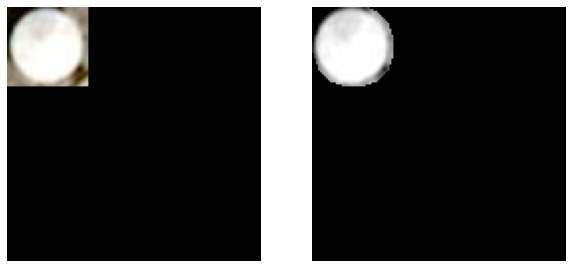

In [55]:
# Load and display a random sample and the bounding boxes
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Customize some image augmentation to reduce the risk of overfitting 

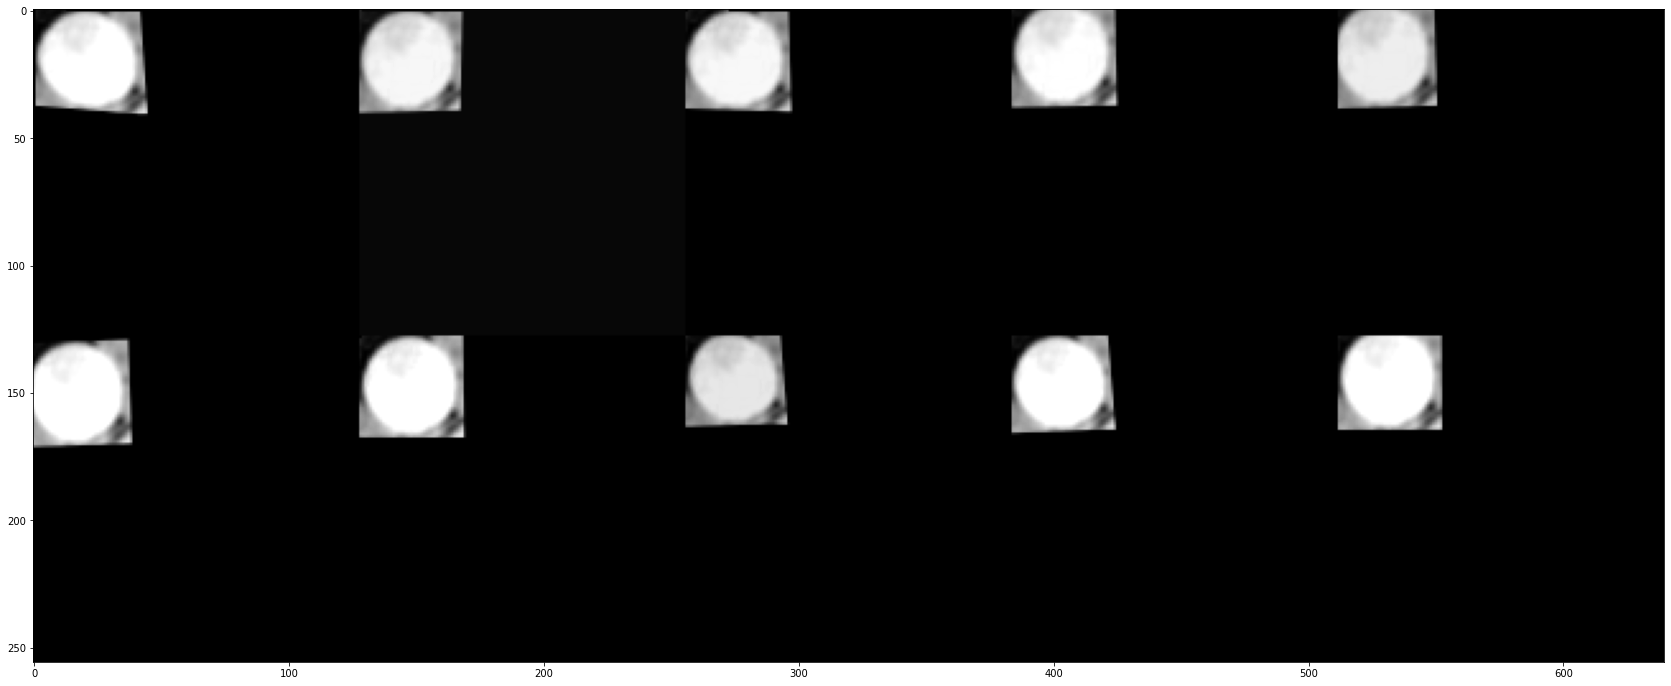

In [56]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            #shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),#,
    #iaa.OneOf([ ## blur or sharpen
    #    iaa.GaussianBlur(sigma=(0.0, 0.1)),
    #    iaa.Sharpen(alpha=(0.0, 0.1)),
    #]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [57]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal!

class OiltankConfig(Config):
    """Configuration for training the oil-tank segmentation model.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'oiltank'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 12 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 12
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 oil-tank classes
    
    # if no resizing is selected:
    IMAGE_MIN_DIM = CHIP_SIDE
    IMAGE_MAX_DIM = CHIP_SIDE
    IMAGE_RESIZE_MODE = 'none'
    # alternatively:
    #IMAGE_MIN_DIM = 64
    #IMAGE_MAX_DIM = 128

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) # anchor side in pixels

    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), i.e. 12230/8 = 1020
    # and so should VALIDATION_STEPS;  i.e.  1360/8 = 110
    # we chose lower number of steps to make our training possible
    # in about 4h. However and as a consequence of our choise we will
    # see abrupt increases in train and validation loss due to the 
    # infrequent update of the weights.
    STEPS_PER_EPOCH = 200 #it should be set to 1020, this would take over 1h per epoch
    VALIDATION_STEPS = 100 #it should be set to 110

    # Reduce training ROIs per image because the images are small 
    # and contain only a few objects at best.
    TRAIN_ROIS_PER_IMAGE = 24 
    MAX_GT_INSTANCES = 12
   
    DETECTION_MAX_INSTANCES = 12
    DETECTION_MIN_CONFIDENCE = 0.9 # insist on clear detections
    DETECTION_NMS_THRESHOLD = 0.5 # background can be misclassified, 
    # make sure NMS prevents tanks and nearby rings of soil coming together

    ## balance out losses
    # - rpn_class_loss: How well the Region Proposal Network separates background with objects
    # - rpn_bbox_loss : How well the RPN localize objects
    # - mrcnn_bbox_loss : How well the Mask RCNN localize objects
    # - mrcnn_class_loss : How well the Mask RCNN recognize each class of object
    # - mrcnn_mask_loss : How well the Mask RCNN segment objects
    LOSS_WEIGHTS = {
        "rpn_class_loss": 12.0,
        "rpn_bbox_loss": 1.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.6
    }

config = OiltankConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     12
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        12
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 12
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 12.0, 'rpn_bbox_loss': 1.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.6}
MASK_POOL_SIZE                 14
MASK_SHAPE              

Time to train the model! Note that training even a basic model can take a few hours.

**Note:** the following model is for demonstration purpose only. We have limited the training to only a few epochs, and have set nominal values for the Oiltank Configuration to reduce run-time.


In [58]:
# create the model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

# Load the weights. Exclude the last layers because they require a matching 
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [59]:
# set the learning rate
LEARNING_RATE = 0.0001

# suppress warnings
import warnings 
warnings.filterwarnings("ignore")

In [60]:
# review the network architecture
# the image file is too large. Download it locally and review it
model.plot()

In [ ]:
# review the network architecture
model.summary()

**INFO:** in the following we will compute a series of training sessions. 

- In session 1 we will focus on the heads of the model as we are excluding the end layer COCO weights for the purpose of transfer learning. Loss is expected to be a bit bumpy. We will use twice the LR to accelerate computation.
- In section 2 we will train the full network to fine tune it to our data. We will use the original LR. If no overfitting occus we expect a smooth and progressive decline of both the training and validation loss.
- In section 3, and aiming for bringing the validation loss to about 0.2 we will continue trainiing but with a smaller LR to allow the network to register small changes in weights. 
- Follow-up sessions can be added if the objective is not met. 

**WARNING:** In the following, if after executing it you get an error message:
```
ResourceExhaustedError:  OOM when allocating tensor with shape[3200,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc	 [[node mrcnn_mask_deconv_1/conv2d_transpose (defined at /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3009) ]]Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. [Op:__inference_keras_scratch_graph_119840]Function call stack:keras_scratch_graph
```
go back to your configuration class and set the IMAGES_PER_GPU to a smaller number

In [ ]:
# first we train only the heads, with twice the learning rate for faster execution
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=6,
            layers='heads',
            augmentation=augmentation)

# if this is your first run:
history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /content/Mask-RCNN-hacked/log/oiltank20210712T0647/mask_rcnn_oiltank_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

In [ ]:
# then, all layers are trained to fine-tune the model to our data, for another 6 epochs.
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=12,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=0.0001

Checkpoint Path: /content/Mask-RCNN-hacked/log/oiltank20210712T0647/mask_rcnn_oiltank_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

In [ ]:
# lastly we train all layers at a reduced LR for another 12 epochs
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=24,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 12. LR=2e-05

Checkpoint Path: /content/Mask-RCNN-hacked/log/oiltank20210712T0647/mask_rcnn_oiltank_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

Model training requires approximately 55min + 60min + 125min = 4h approximately to complete 

### A brief look into the history

In [ ]:
# get the model training stats
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

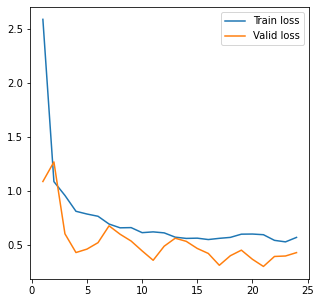

In [ ]:
# plot the training vs validation loss, and others 
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.show()

From the plot above one can see a smooth reduction of training loss which is a good indication regarding the model's complexity. I.e. no evident signs of overfitting can be seen. Flactuations in the validation loss can be due to many reasons. Overall and if one was to fit a polynomial, between the edge points of the orange line, the result would be a curve following the trends of the blue line. 

Note that increasing the number of epochs by running an additional training session may not help much as the model seems to be saturated, i.e. it cannot be improved further. It this case, re-adjustment of the hyperparameters is needed followed by a repetition of the training sessions.

### Select the best weights


In [ ]:
# select the best weights based on the lowest validation loss
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 21 0.30374497175216675


In [ ]:
# select best model 
LOG_DIR = "/content/Mask-RCNN-hacked/log/"
dir_names = next(os.walk(LOG_DIR))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(LOG_DIR, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/Mask-RCNN-hacked/log/oiltank20210712T0647/mask_rcnn_oiltank_0021.h5


## Model Inference <a name="model-inference"></a>


### Get the best model/weights

If stored externally, modify the path below to bring up a copy of your best  weights file into this project. Otherwise **skip** the next 2 code blocks.

In [63]:
%cp /content/drive/MyDrive/deep-learning/mask-rcnn/logs/mask_rcnn_oiltank_0021.h5 /content/

In [64]:
model_path = "/content/mask_rcnn_oiltank_0021.h5"

### Create the inference model configured with the best weights

In [65]:
class InferenceConfig(OiltankConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/mask_rcnn_oiltank_0021.h5


### Demo a random set of GT vs predictions from images in the Validation Set

In [66]:
# set the color for the airplanes class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


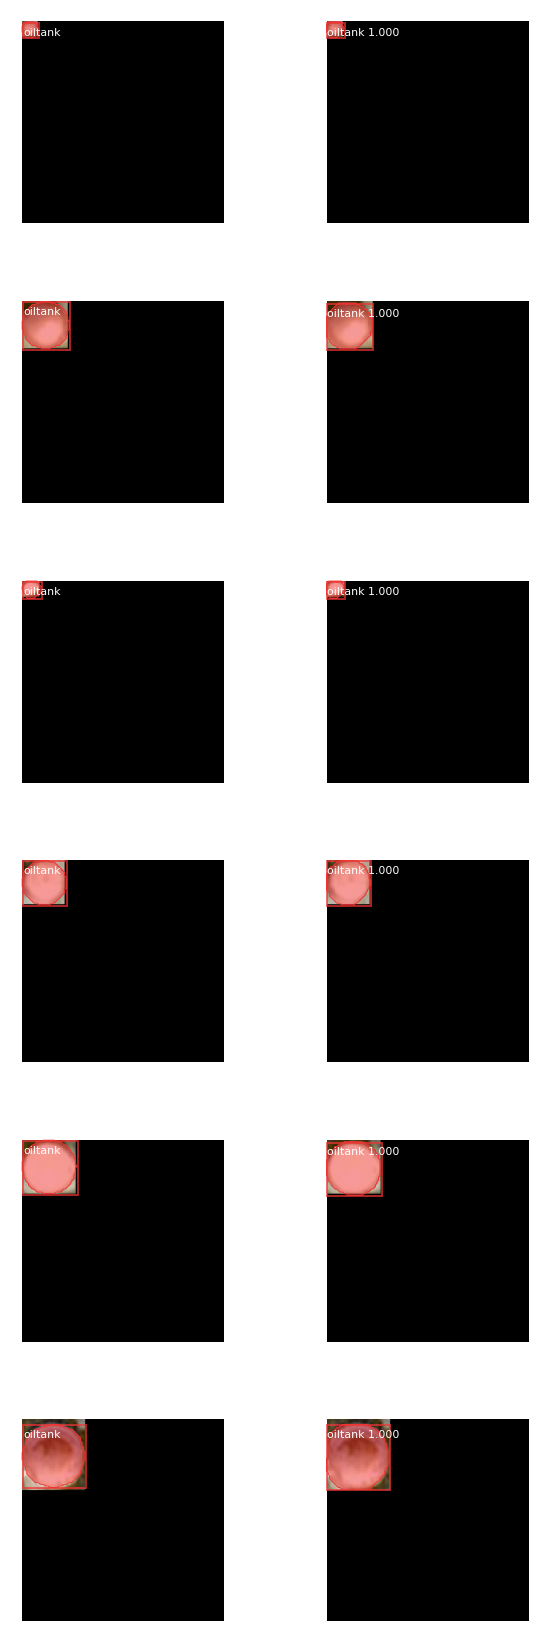

In [67]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

### Experiment with a small test set of previously unseen chips

get the test_chip set

In [ ]:
!wget https://github.com/georgiosouzounis/instance-segmentation-mask-rcnn/raw/main/data/test_chips.zip -O /content/test_chips.zip

In [69]:
%cd /content/

/content


In [ ]:
!unzip /content/test_chips.zip 
%rm /content/test_chips.zip 

In [71]:
test_dir = "/content/test_chips/"

# Get the test image filenames
test_image_set = glob.glob(test_dir+'/'+'*.png')
test_image_set = list(set(test_image_set))

In [74]:
CLASS_NAMES = ["background", "oiltank"]
RES_DIR = "/content/results/"
import mrcnn

In [72]:
def vis_and_save(image_id, _min_score):
  image = cv2.imread(image_id)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = model.detect([image]) #, verbose=1)
  r = results[0]

  basename = os.path.basename(image_id).split(".")[0]
  print("displaying chip: " + basename)

  mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'],min_score=_min_score)
  outfname =  RES_DIR + basename + "_seg.png"
  cv2.imwrite(outfname, image)


  0%|          | 0/12 [00:00<?, ?it/s]

displaying chip: test7


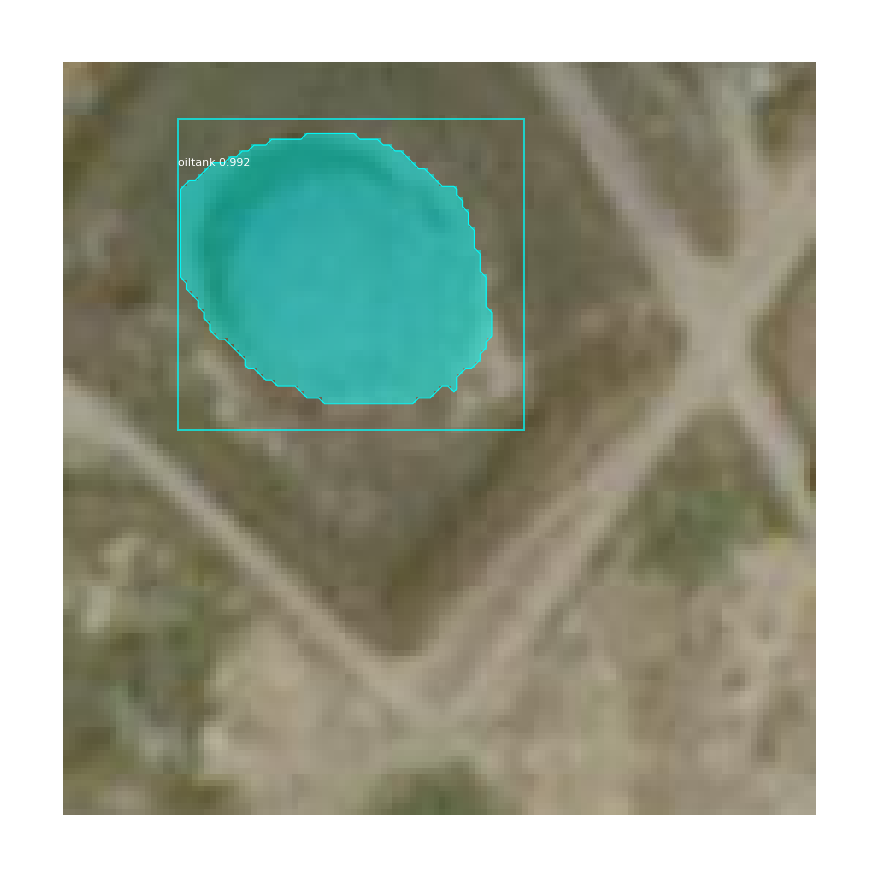

  8%|▊         | 1/12 [00:00<00:10,  1.07it/s]

displaying chip: test3


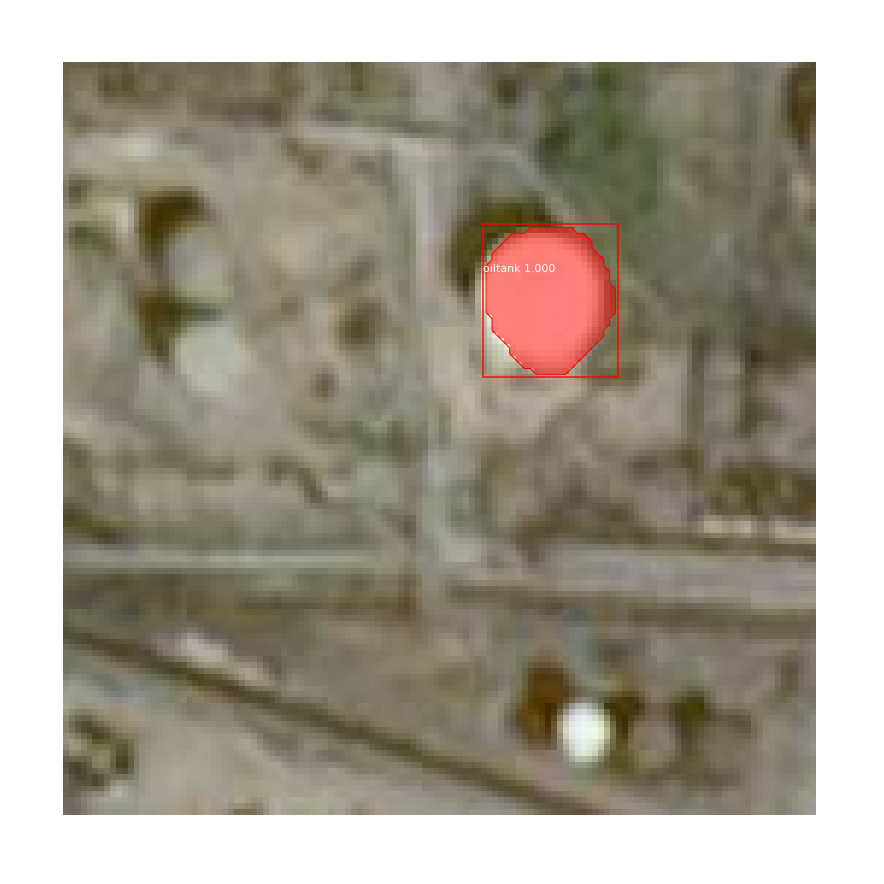

 17%|█▋        | 2/12 [00:01<00:09,  1.06it/s]

displaying chip: test9

*** No instances to display *** 



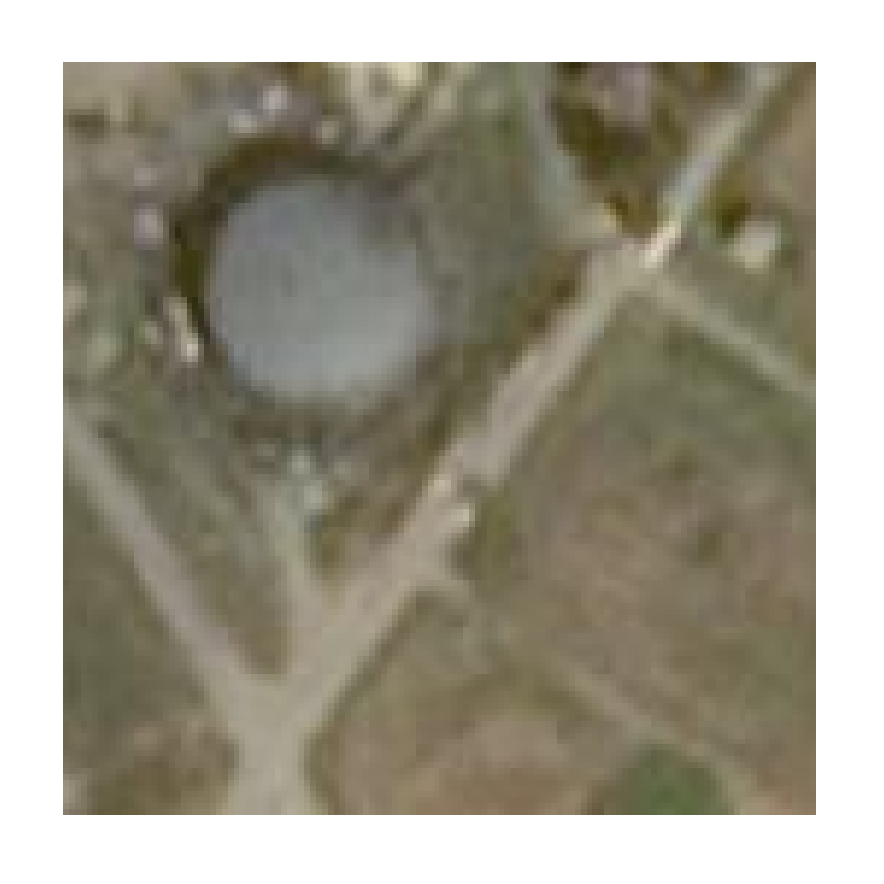

 25%|██▌       | 3/12 [00:02<00:08,  1.08it/s]

displaying chip: test2


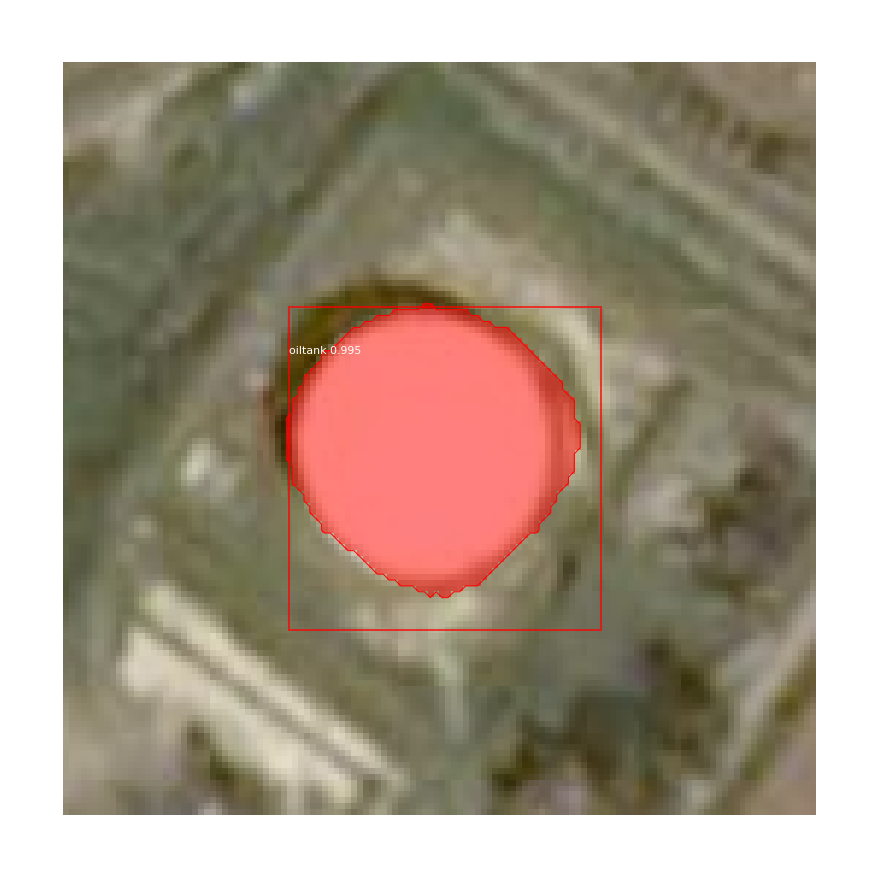

 33%|███▎      | 4/12 [00:03<00:07,  1.07it/s]

displaying chip: test11


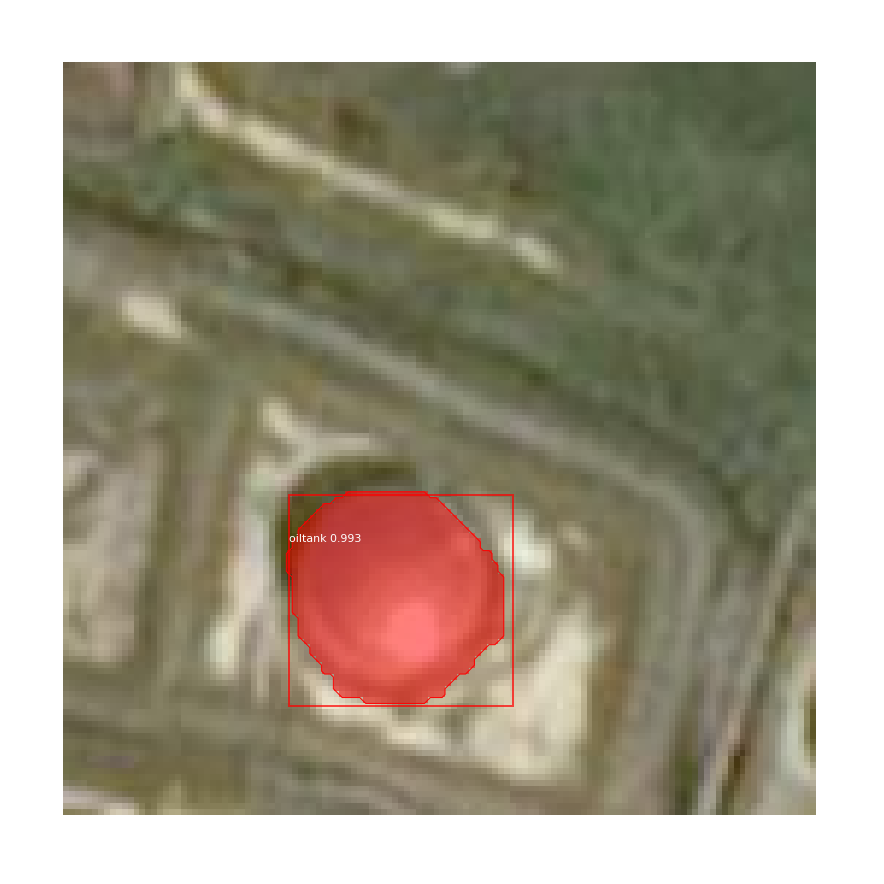

 42%|████▏     | 5/12 [00:04<00:06,  1.07it/s]

displaying chip: test10


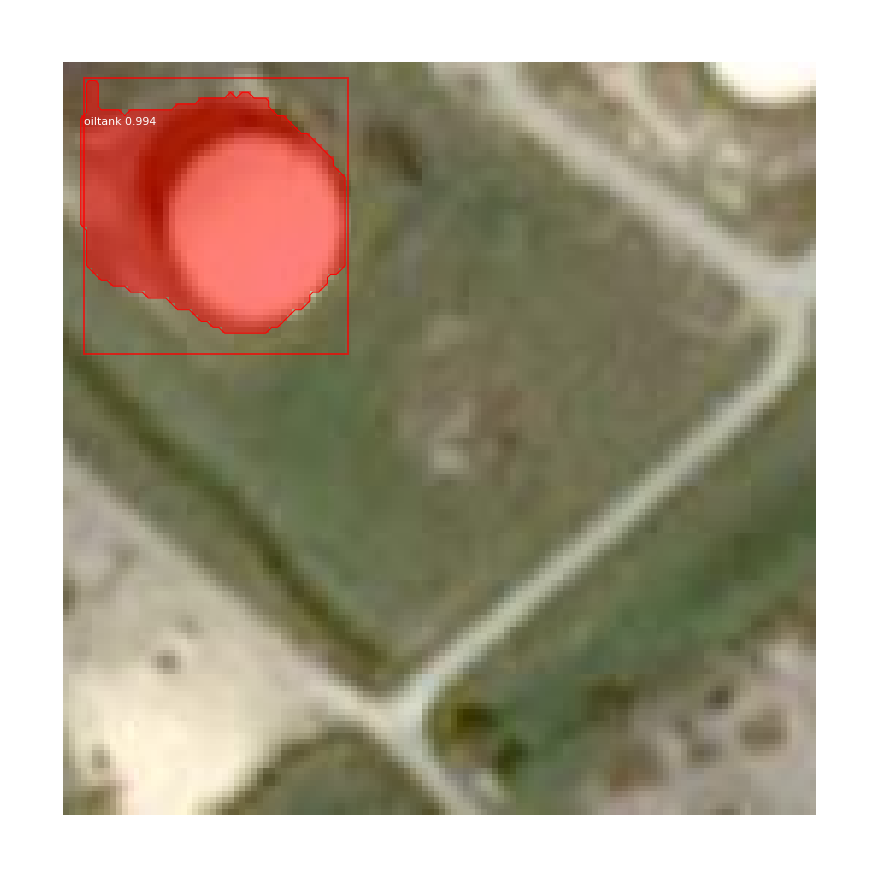

 50%|█████     | 6/12 [00:05<00:05,  1.06it/s]

displaying chip: test5


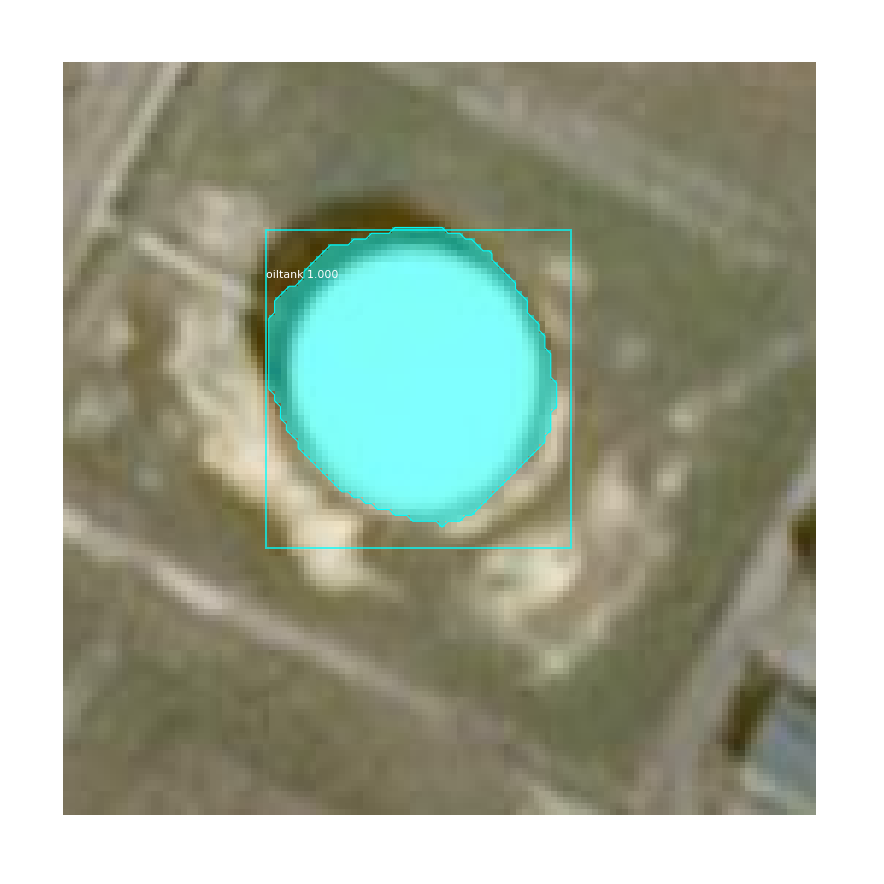

 58%|█████▊    | 7/12 [00:06<00:04,  1.06it/s]

displaying chip: test6


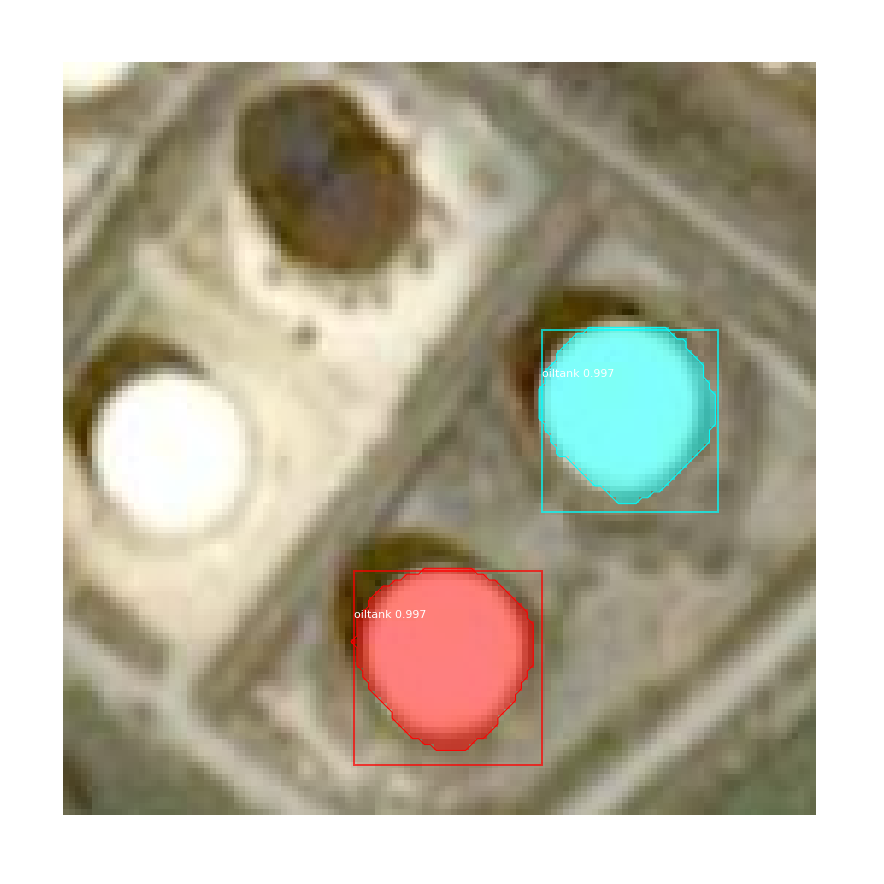

 67%|██████▋   | 8/12 [00:07<00:03,  1.05it/s]

displaying chip: test4


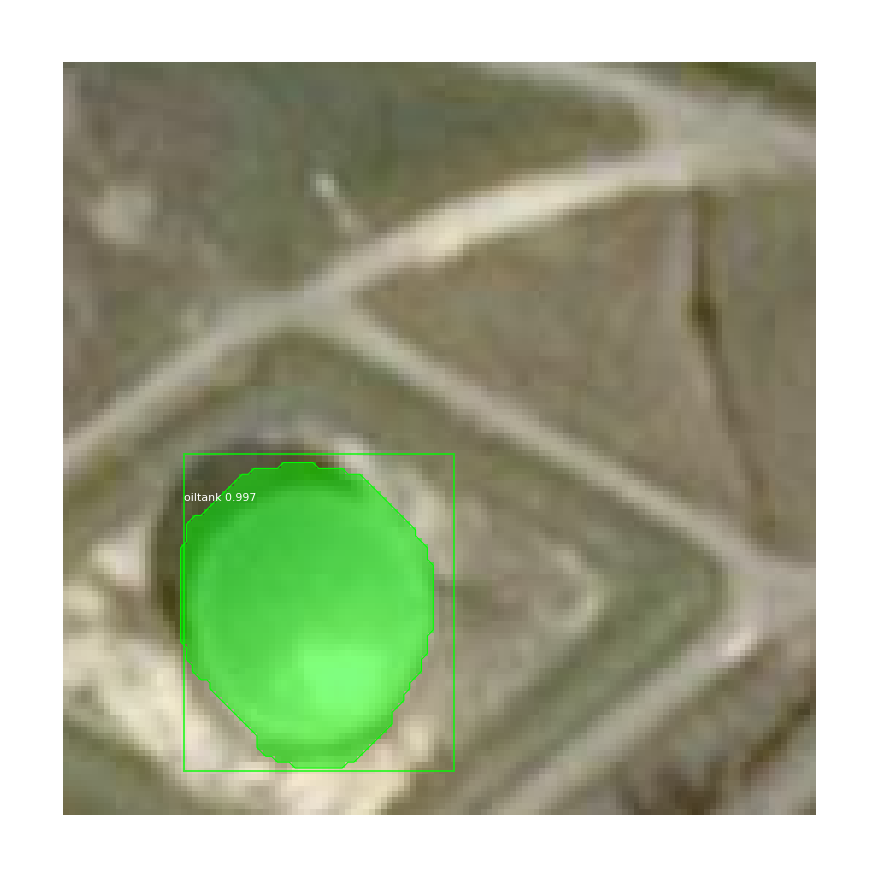

 75%|███████▌  | 9/12 [00:08<00:02,  1.06it/s]

displaying chip: test12


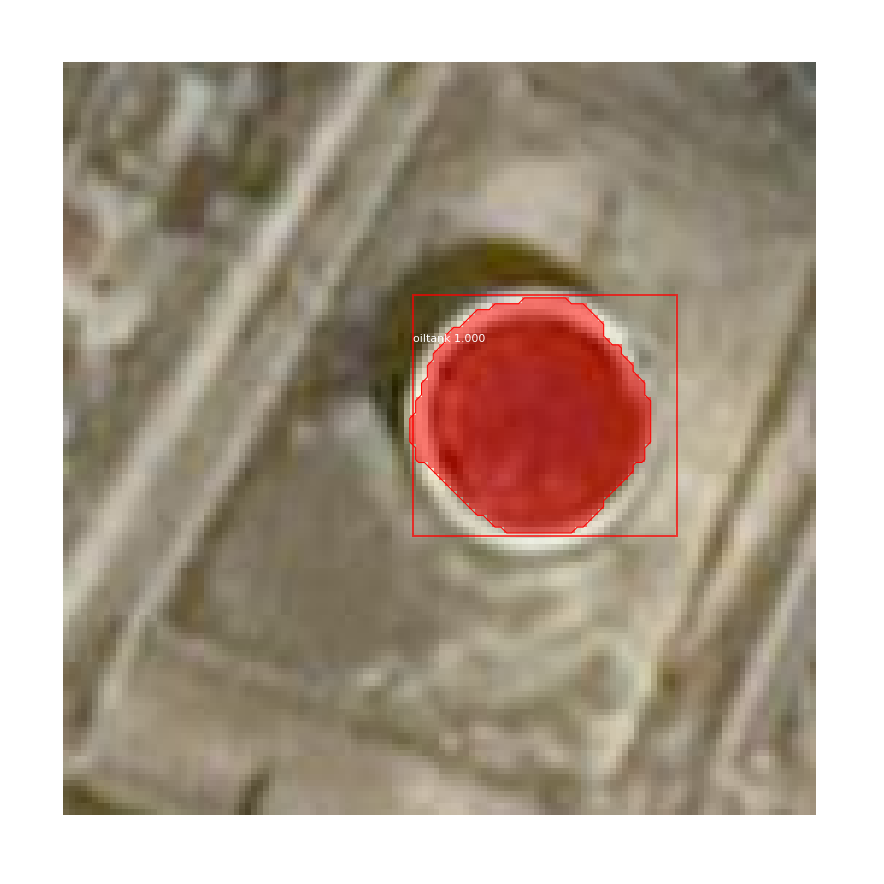

 83%|████████▎ | 10/12 [00:09<00:01,  1.06it/s]

displaying chip: test1


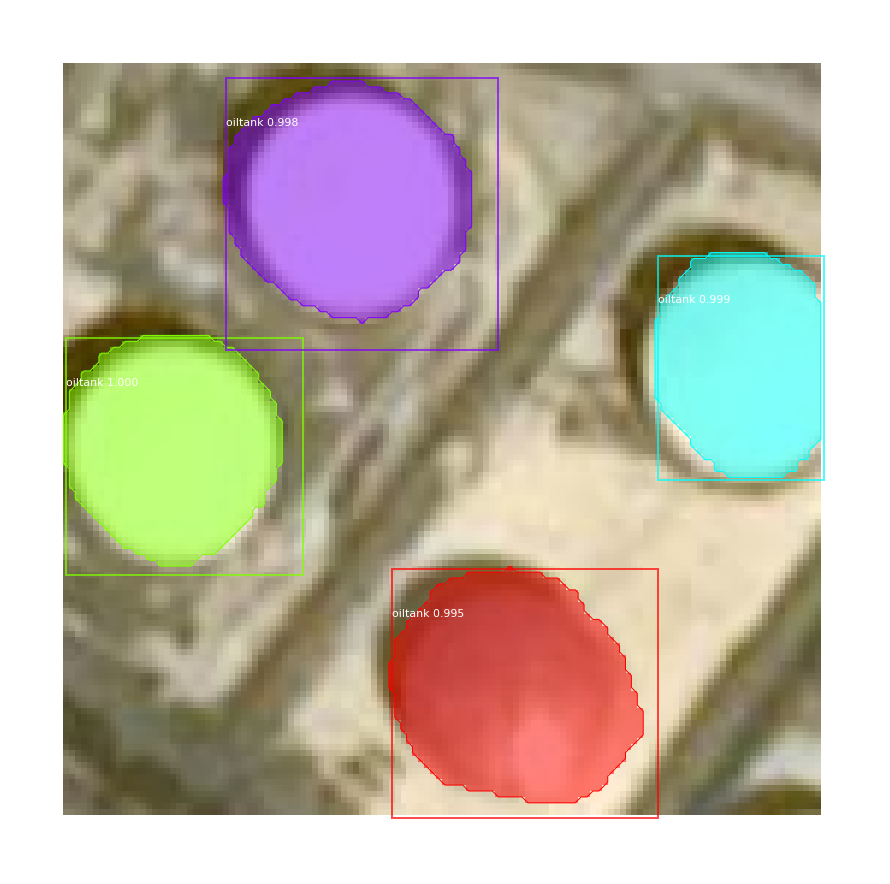

 92%|█████████▏| 11/12 [00:10<00:00,  1.04it/s]

displaying chip: test8


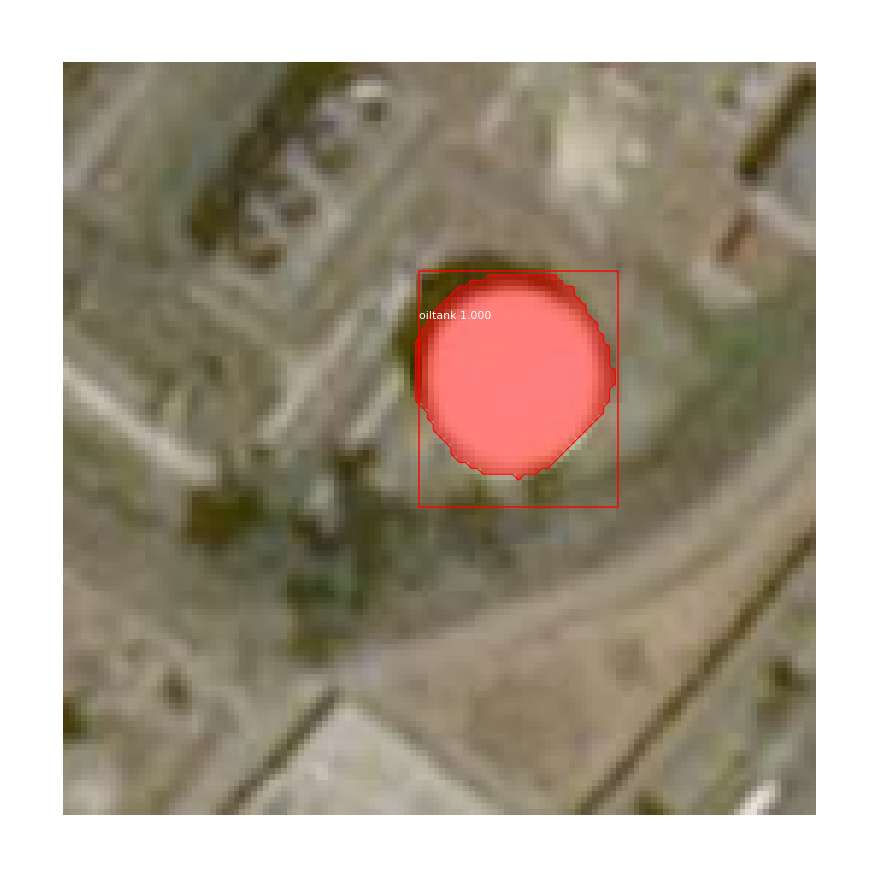

100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


In [76]:
# set the min score threshold
_min_score = 0.99

# display the results for all chips
for image_id in tqdm(test_image_set):
  vis_and_save(image_id, _min_score)

## Conclusions <a name="conclusions"></a>


Reviewing the results shows that the model performs rather well but in some cases has a hard time seperating accurately the the oil-tank perimeter from the tank itself. This is referred to as leakage and is primarily due to the very little information on the background. Recall that all chips are focused on the tank with some minor background areas seen at the corners of the BBox and the rest of the chip content is black. This calls for a better annotation strategy.

Regarding the successful detections, they apper to be proper though it is evident that some additional improvement in the model (loss reduction) would have been appreciated.

Lastly, we see one False Negative and that is on a type of tank that is not represented sufficiently in our dataset. More training instances of this kind would help.



### Examples of 'leakage'

displaying chip: test6


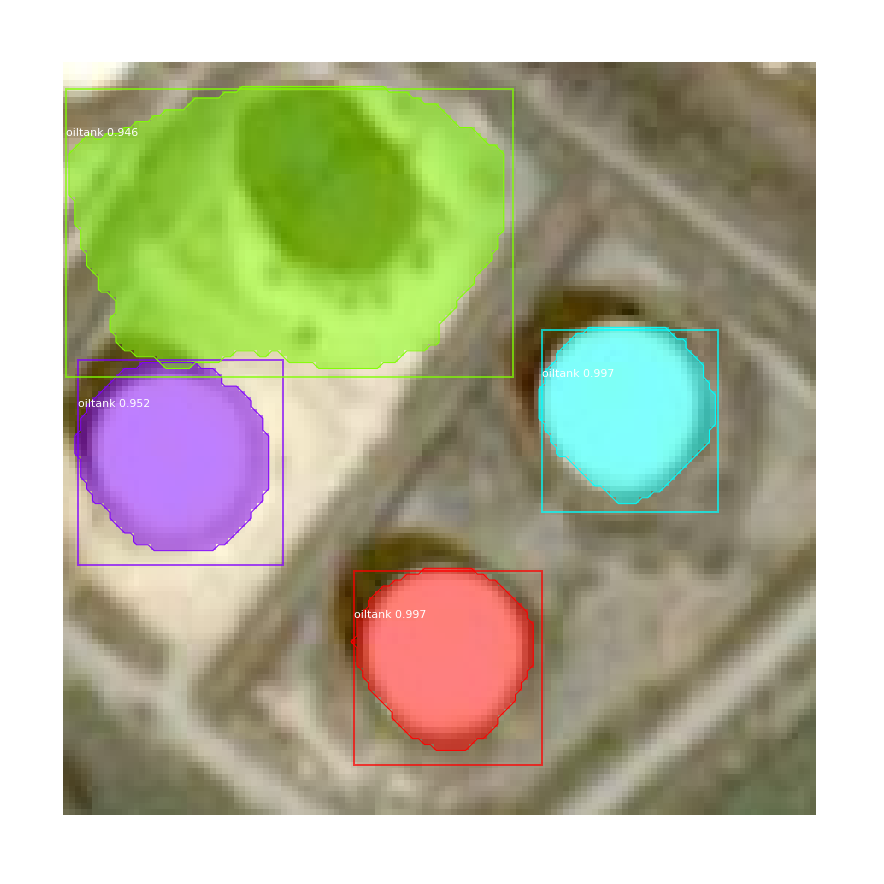

In [77]:
vis_and_save("/content/test_chips/test6.png", 0.94)

### Examples of 'False Negatives' 

displaying chip: test9

*** No instances to display *** 



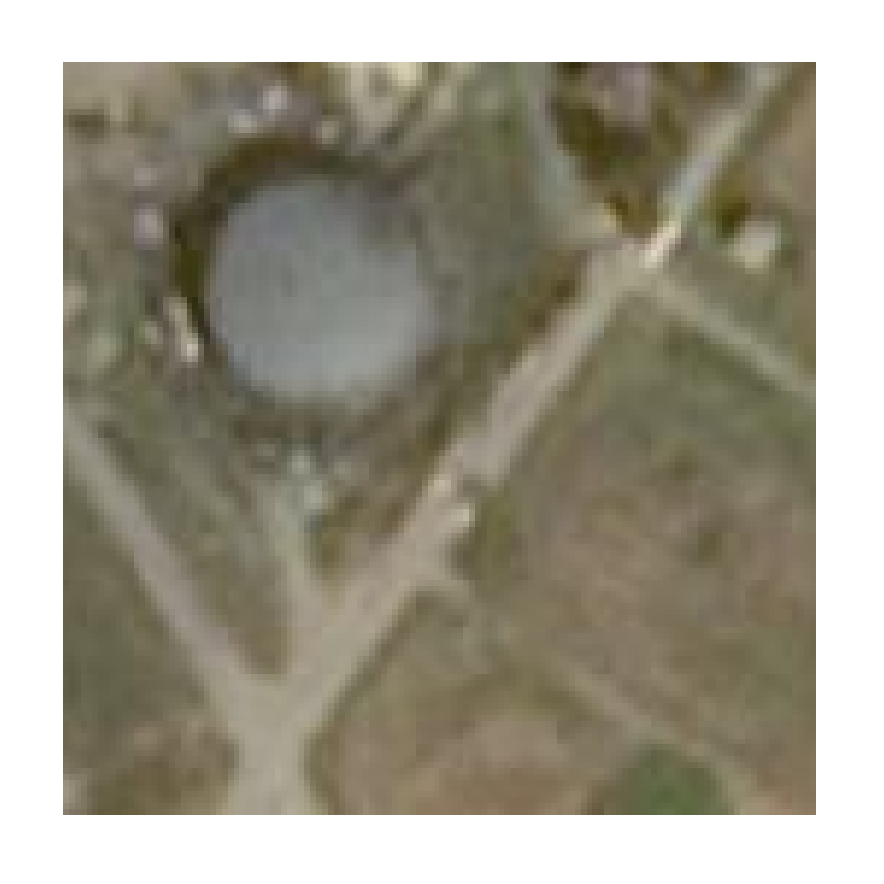

In [80]:
vis_and_save("/content/test_chips/test9.png", 0.0)